In [3]:
import numpy as np
import pickle
import os
import sys
import itertools as it
import string

import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

import tqdm
import contextlib

import proplot as pplt

sys.path.append('../GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA_wLAR import *

from UQpy.distributions import Normal, Uniform, JointIndependent

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "stix" # "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15


USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [4]:
if not os.path.exists('data/data_sugarscape/GSA_results/GLD/GDMaps'):
    os.makedirs('data/data_sugarscape/GSA_results/GLD/GDMaps')
    
if not os.path.exists('data/data_sugarscape/GSA_results/GLD/PCE_GSA'):
    os.makedirs('data/data_sugarscape/GSA_results/GLD/PCE_GSA')
    
if not os.path.exists('plots/Sugarscape'):
    os.makedirs('plots/Sugarscape')



# GDMaps with GLD using LMM

## Overview of parameters:

- Population 100: $p=\{3,10\}$
- Population 320: $p=\{4,8\}$

# Plots

In [5]:
PATH_TO_RESULTS = "data/data_sugarscape/GSA_results/GLD/"

## Scatterplots: diffusion coordinates

In [6]:
g_data_all_runs = []
coord_data = []

for i, p in enumerate([3,10]):
    GDMaps_results_100 = np.load(PATH_TO_RESULTS + f"GDMaps/GLD_GDMaps_parsim_pop100_l34_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    d_cooords_diff_runs  = GDMaps_results_100['x4']
    coord = GDMaps_results_100['x3']
    
    g_data_all_runs.append(d_cooords_diff_runs)
    coord_data.append(coord)
    
for i, p in enumerate([4,8]):
    GDMaps_results_320 = np.load(PATH_TO_RESULTS + f"GDMaps/GLD_GDMaps_parsim_pop320_l34_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    d_cooords_diff_runs  = GDMaps_results_320['x4']
    coord = GDMaps_results_320['x3']
    
    g_data_all_runs.append(d_cooords_diff_runs)
    coord_data.append(coord)

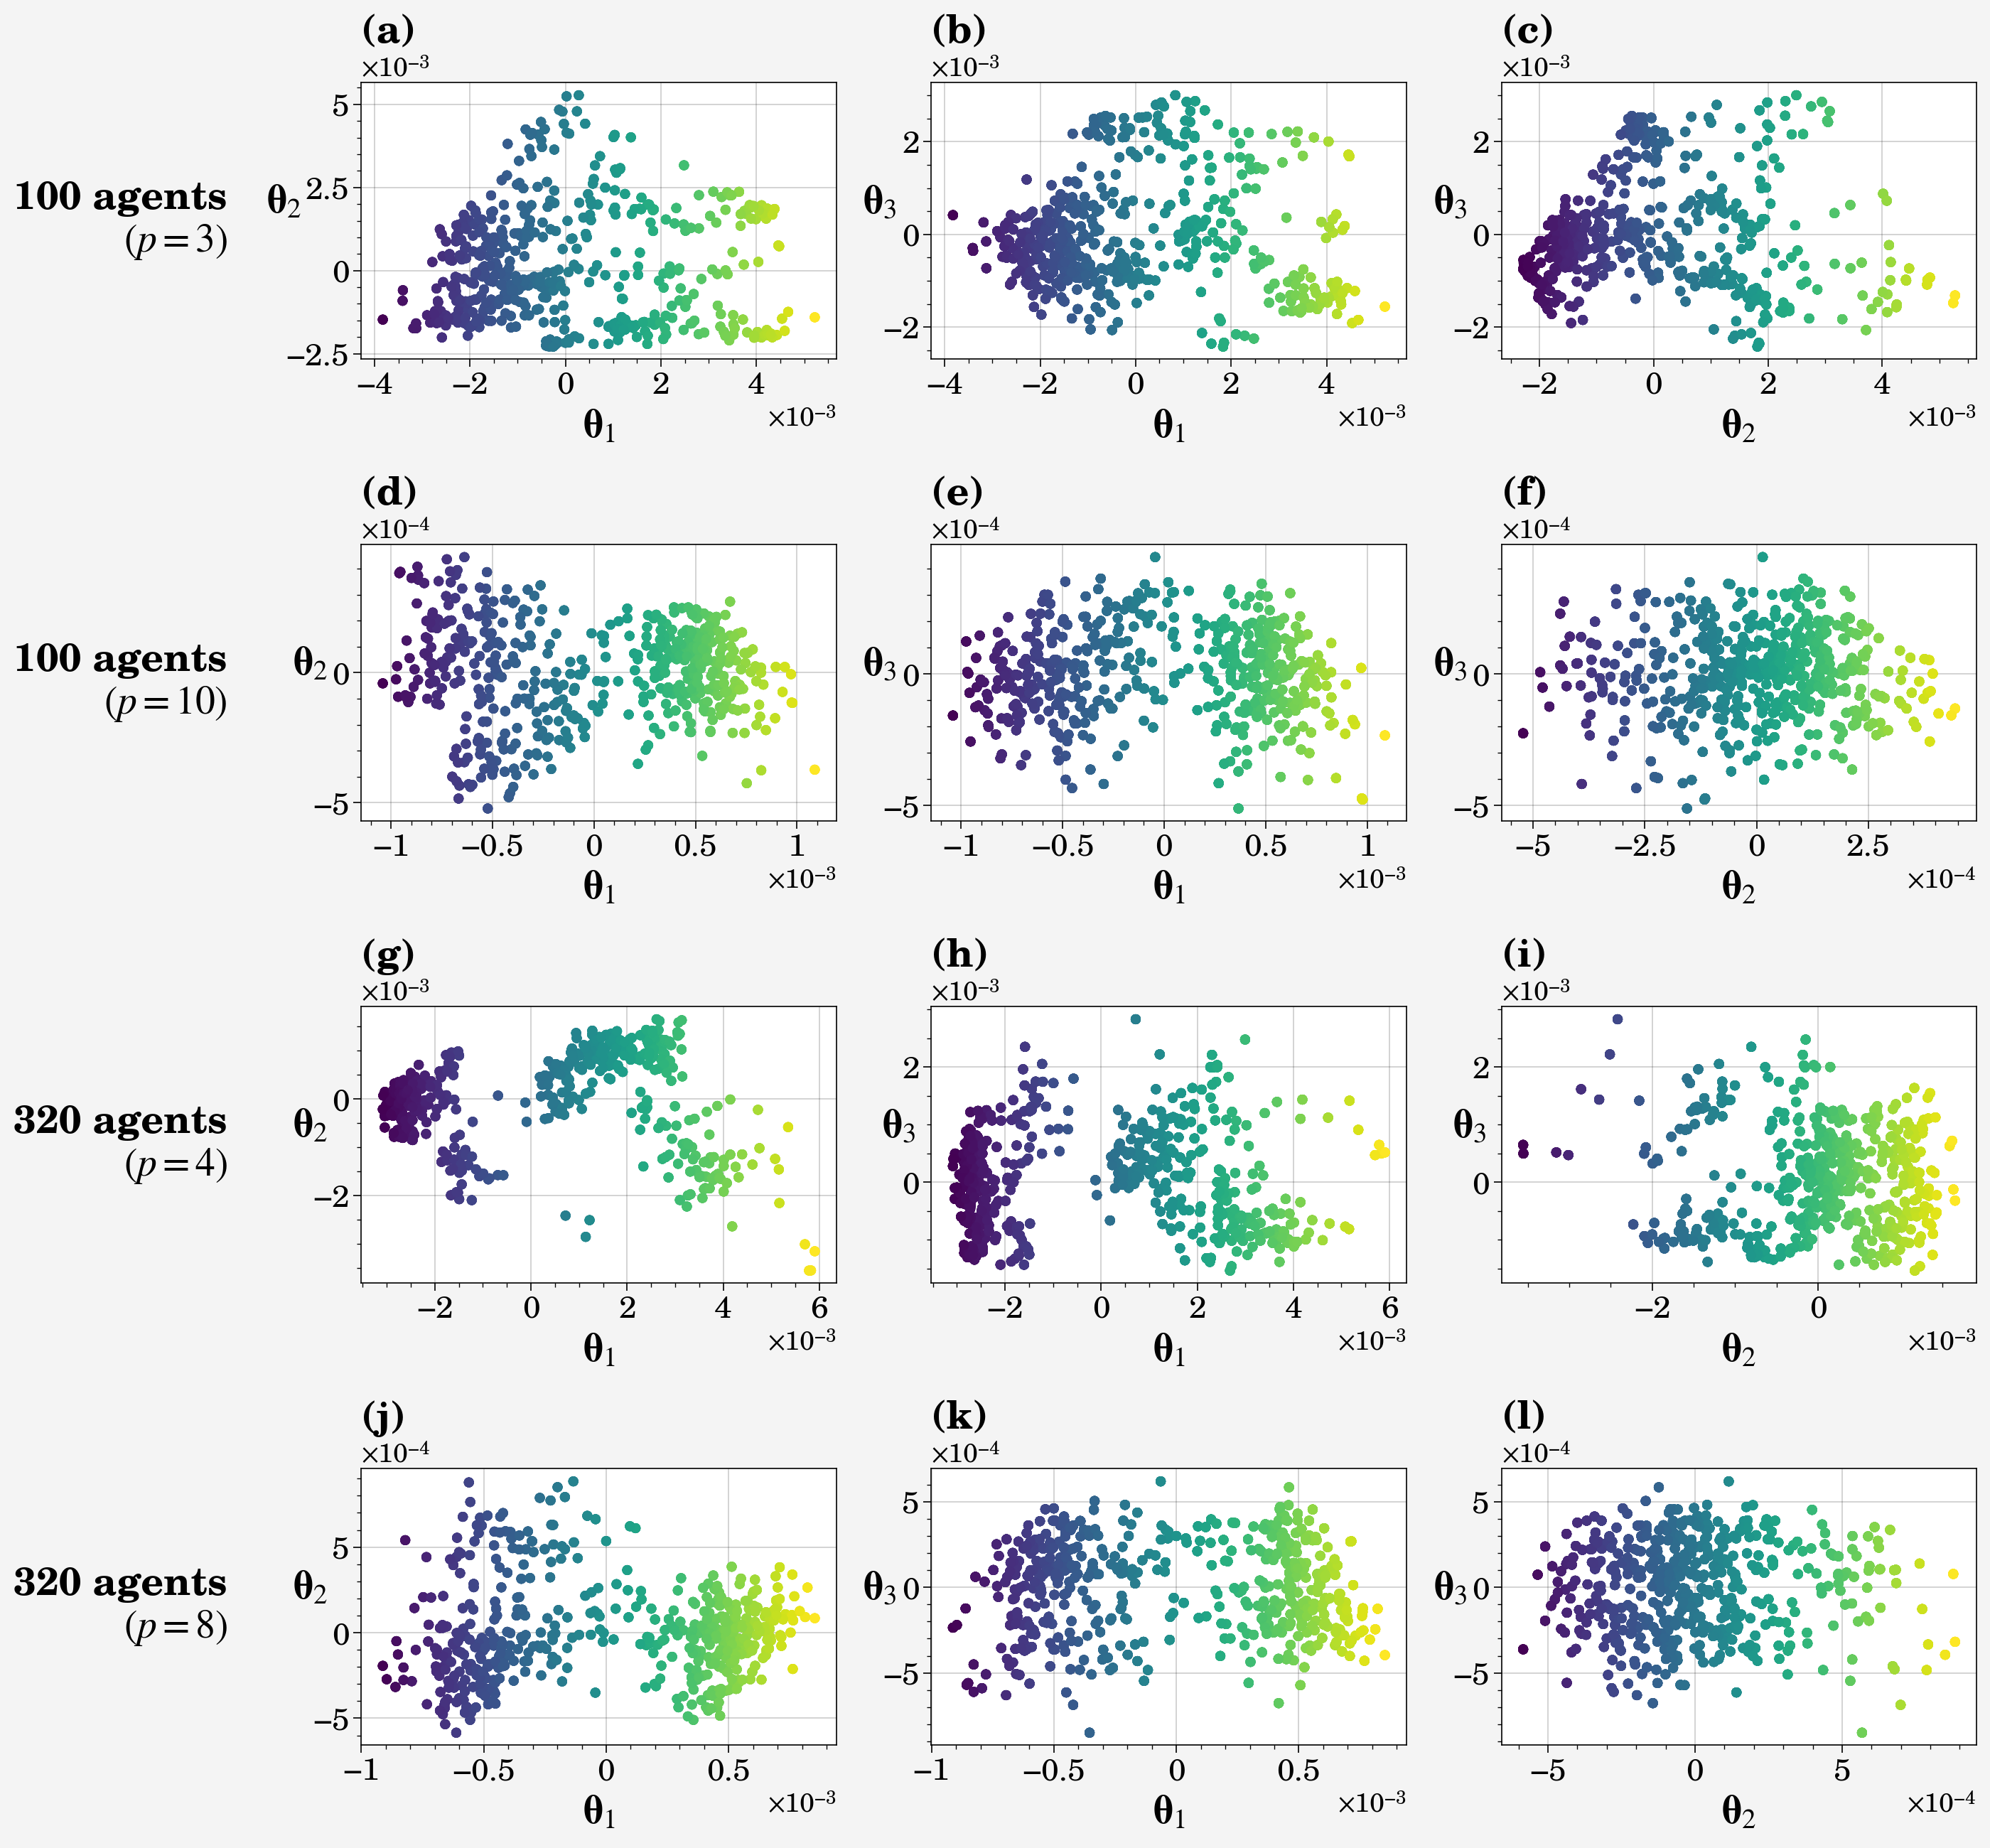

In [7]:
run = 5

fig, axs = pplt.subplots(ncols=3, nrows=4, figsize=(14, 13), sharex=False, sharey=False)

for row, g_data in enumerate(g_data_all_runs):
    axs[row*3].scatter(g_data[run][:, 0][:512*5], g_data[run][:, 1][:512*5], 
                       c=g_data[run][:, 0][:512*5], cmap='viridis', 
                       s=20)
#     edgecolors='k', linewidth=0.2)

    axs[row*3].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][0]))
    axs[row*3].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][1]),
                         labelpad=10)
    
    axs[row*3+1].scatter(g_data[run][:, 0], g_data[run][:, 2], 
                         c=g_data[run][:, 0], cmap='viridis', 
                         s=20)
#     edgecolors='k', linewidth=0.2)
    axs[row*3+1].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][0]))
    axs[row*3+1].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][2]),
                            labelpad=10)

    axs[row*3+2].scatter(g_data[run][:, 1], g_data[run][:, 2], 
                         c=g_data[run][:, 1], cmap='viridis', 
                         s=20)
#     edgecolors='k', linewidth=0.2)
    axs[row*3+2].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][1]))
    axs[row*3+2].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][run][2]),
                            labelpad=10)
    
    for ax in axs:
        ax.ticklabel_format(style="scientific", scilimits=(-2, -3))
        ax.format(abc='(a)',
                  rc_kw={'title.size': 17,
                         'label.size': 20,
                         'tick.labelsize': 16,
                         'abc.size':  20,
                         'title.pad': 20,
                         'leftlabel.size': 20,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 20.0,
                         'leftlabel.color': "k"})
        

axs.format(leftlabels=["100 agents\n"+r"$(p=3)$", "100 agents\n"+r"$(p=10)$",
                       "320 agents\n"+r"$(p=4)$", "320 agents\n"+r"$(p=8)$"])

for i, ax in enumerate(axs):
    ax.yaxis.label.set(rotation='horizontal', ha='left')
    

fig.tight_layout()
plt.savefig(f'plots/Sugarscape/Sugarscape_GLD_dcoords_run{run}.pdf', dpi=300, bbox_inches='tight')
plt.show()       

## Sensitivity Indices

In [7]:
def plot_GSA_OLS_LAR(SIs, suptitle, figsize, legend_n_cols, toplabels, title, top=True):
    
    n_res = len(SIs)
    
    n_d_coord = 3

    param_names = [r"$h_e$", r"$h_m$", r"$h_v$"]
    s_max = np.linspace(2, 15, 14, dtype='int')
    colors=mcp.gen_color(cmap="tab10",n=10)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_res, nrows=3, figsize=figsize, sharex=True, sharey=True)
    
    for d in range(n_d_coord):
        for i, param in enumerate(param_names):
            for j, si in enumerate(SIs):

                axs[d,j].scatter(s_max, si.mean(axis=0)[:, i, d], label=param,
                                 color=colors[i], edgecolor="k", marker=marker_styles[i], 
                                 markersize=80, linewidth=0.4, zorder=3)
                
                axs[d,j].errorbar(s_max, si.mean(axis=0)[:, i, d],
                                  si.var(axis=0, ddof=1)[:, i, d],
                                  markeredgewidth=1.4, color=colors[i],
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1) 
     
   
    axs.format(toplabels=toplabels,
              suptitle=suptitle,
              leftlabels=["1st\n"+r"$\mathbf{\theta}$", 
                         "2nd\n"+r"$\mathbf{\theta}$",
                         "3rd\n"+r"$\mathbf{\theta}$"],)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.set(ylim=(-0.06, 1.04))
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'abc.size' : 20,
                         'title.size': 22,
                         'title.pad': 3.0,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 1.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
    
    ticks = np.linspace(1, 15, 8, dtype='int')
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(param_names, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 5))
        for i in range(len(param_names)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/Sugarscape/' + title, bbox_inches='tight')
    plt.show()

In [9]:
GSA_GLD_100_3 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop100_runs_10_p_3.npz', 
                            allow_pickle=True)

LAR_fo_si_GLD_100_p_3 = GSA_GLD_100_3['x9']
LAR_to_si_GLD_100_p_3 = GSA_GLD_100_3['x10']


GSA_GLD_100_10 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop100_runs_10_p_10.npz', 
                            allow_pickle=True)

LAR_fo_si_GLD_100_p_10 = GSA_GLD_100_10['x9']
LAR_to_si_GLD_100_p_10 = GSA_GLD_100_10['x10']


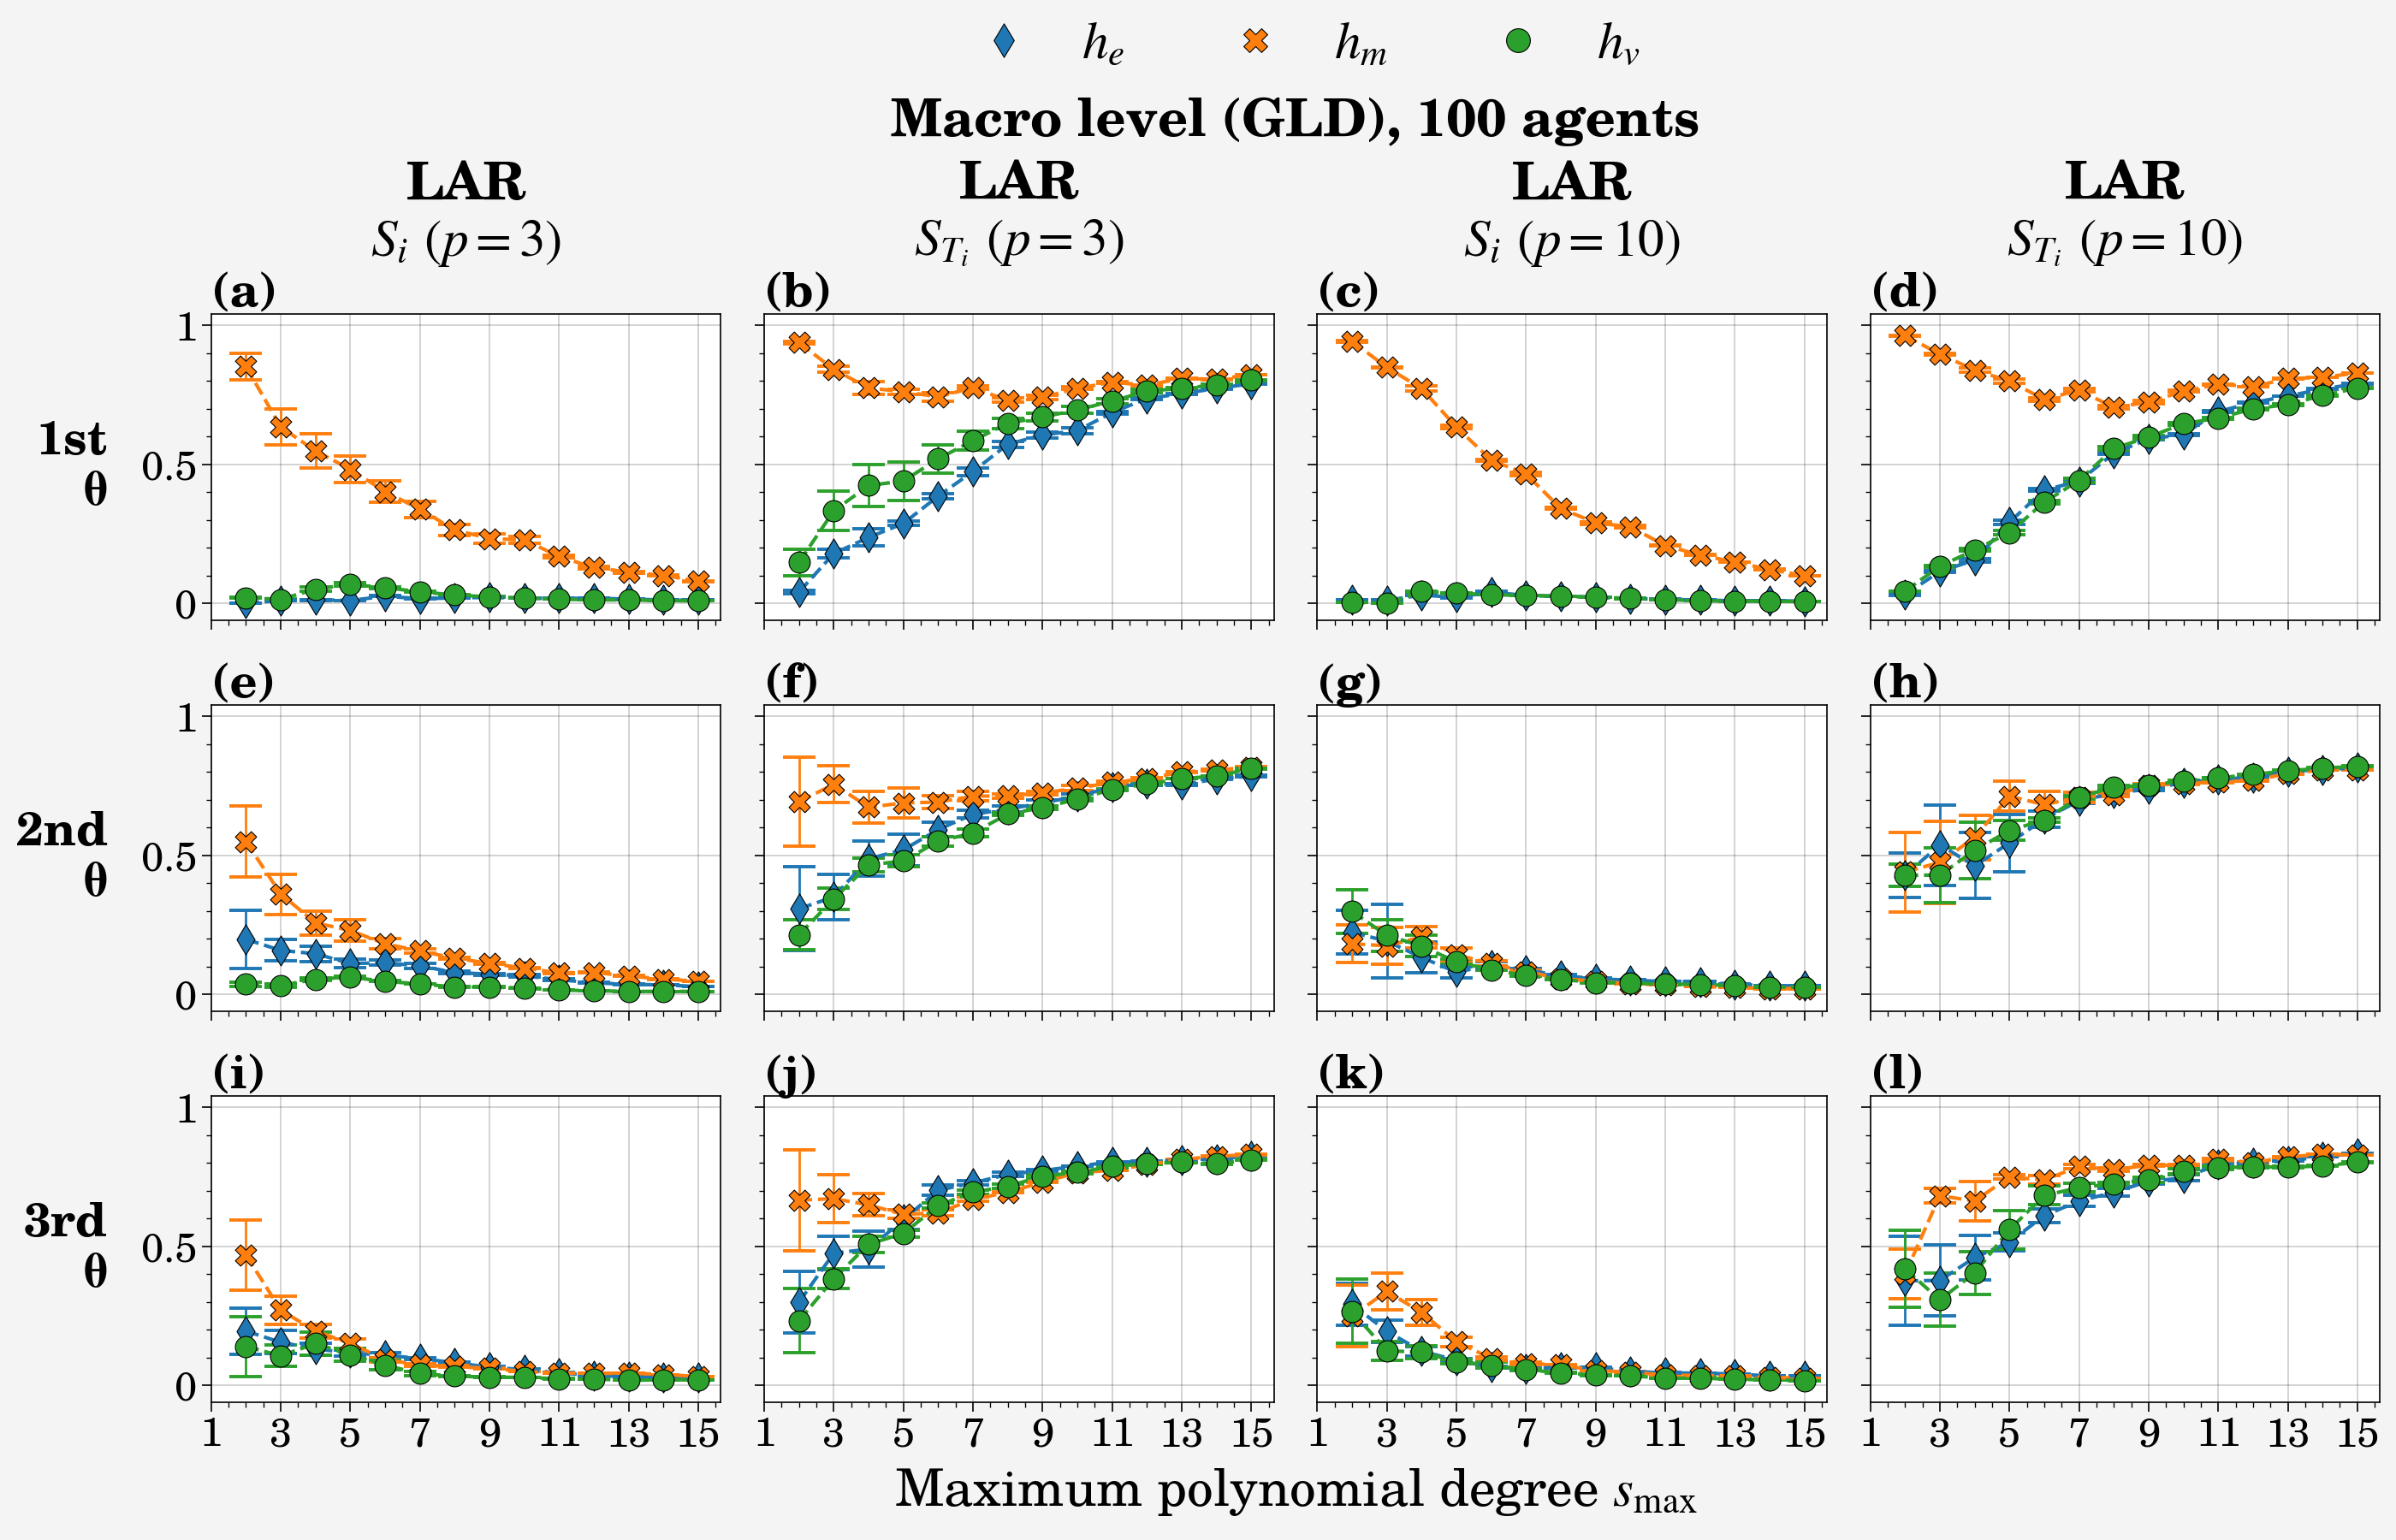

In [10]:
plot_GSA_OLS_LAR(SIs = [LAR_fo_si_GLD_100_p_3, LAR_to_si_GLD_100_p_3, 
                        LAR_fo_si_GLD_100_p_10, LAR_to_si_GLD_100_p_10],
                 figsize = (14, 9),
                 suptitle = "Macro level (GLD), 100 agents", 
                 legend_n_cols  = 3,
                 toplabels = ("LAR\n"+r'$S_{i}$ $({p=3})$', 
                              "LAR\n"+r'$S_{T_i}$ $({p=3})$', 
                              "LAR\n"+r'$S_{i}$ $({p=10})$', 
                              "LAR\n"+r'$S_{T_i}$ $({p=10})$'),
                 title = "SC_GLD_pop100_GSA_LAR.pdf")



In [11]:
GSA_GLD_320_4 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop320_runs_10_p_4.npz', 
                            allow_pickle=True)

LAR_fo_si_GLD_320_p_4 = GSA_GLD_320_4['x9']
LAR_to_si_GLD_320_p_4 = GSA_GLD_320_4['x10']


GSA_GLD_320_8 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop320_runs_10_p_8.npz', 
                            allow_pickle=True)

LAR_fo_si_GLD_320_p_8 = GSA_GLD_320_8['x9']
LAR_to_si_GLD_320_p_8 = GSA_GLD_320_8['x10']

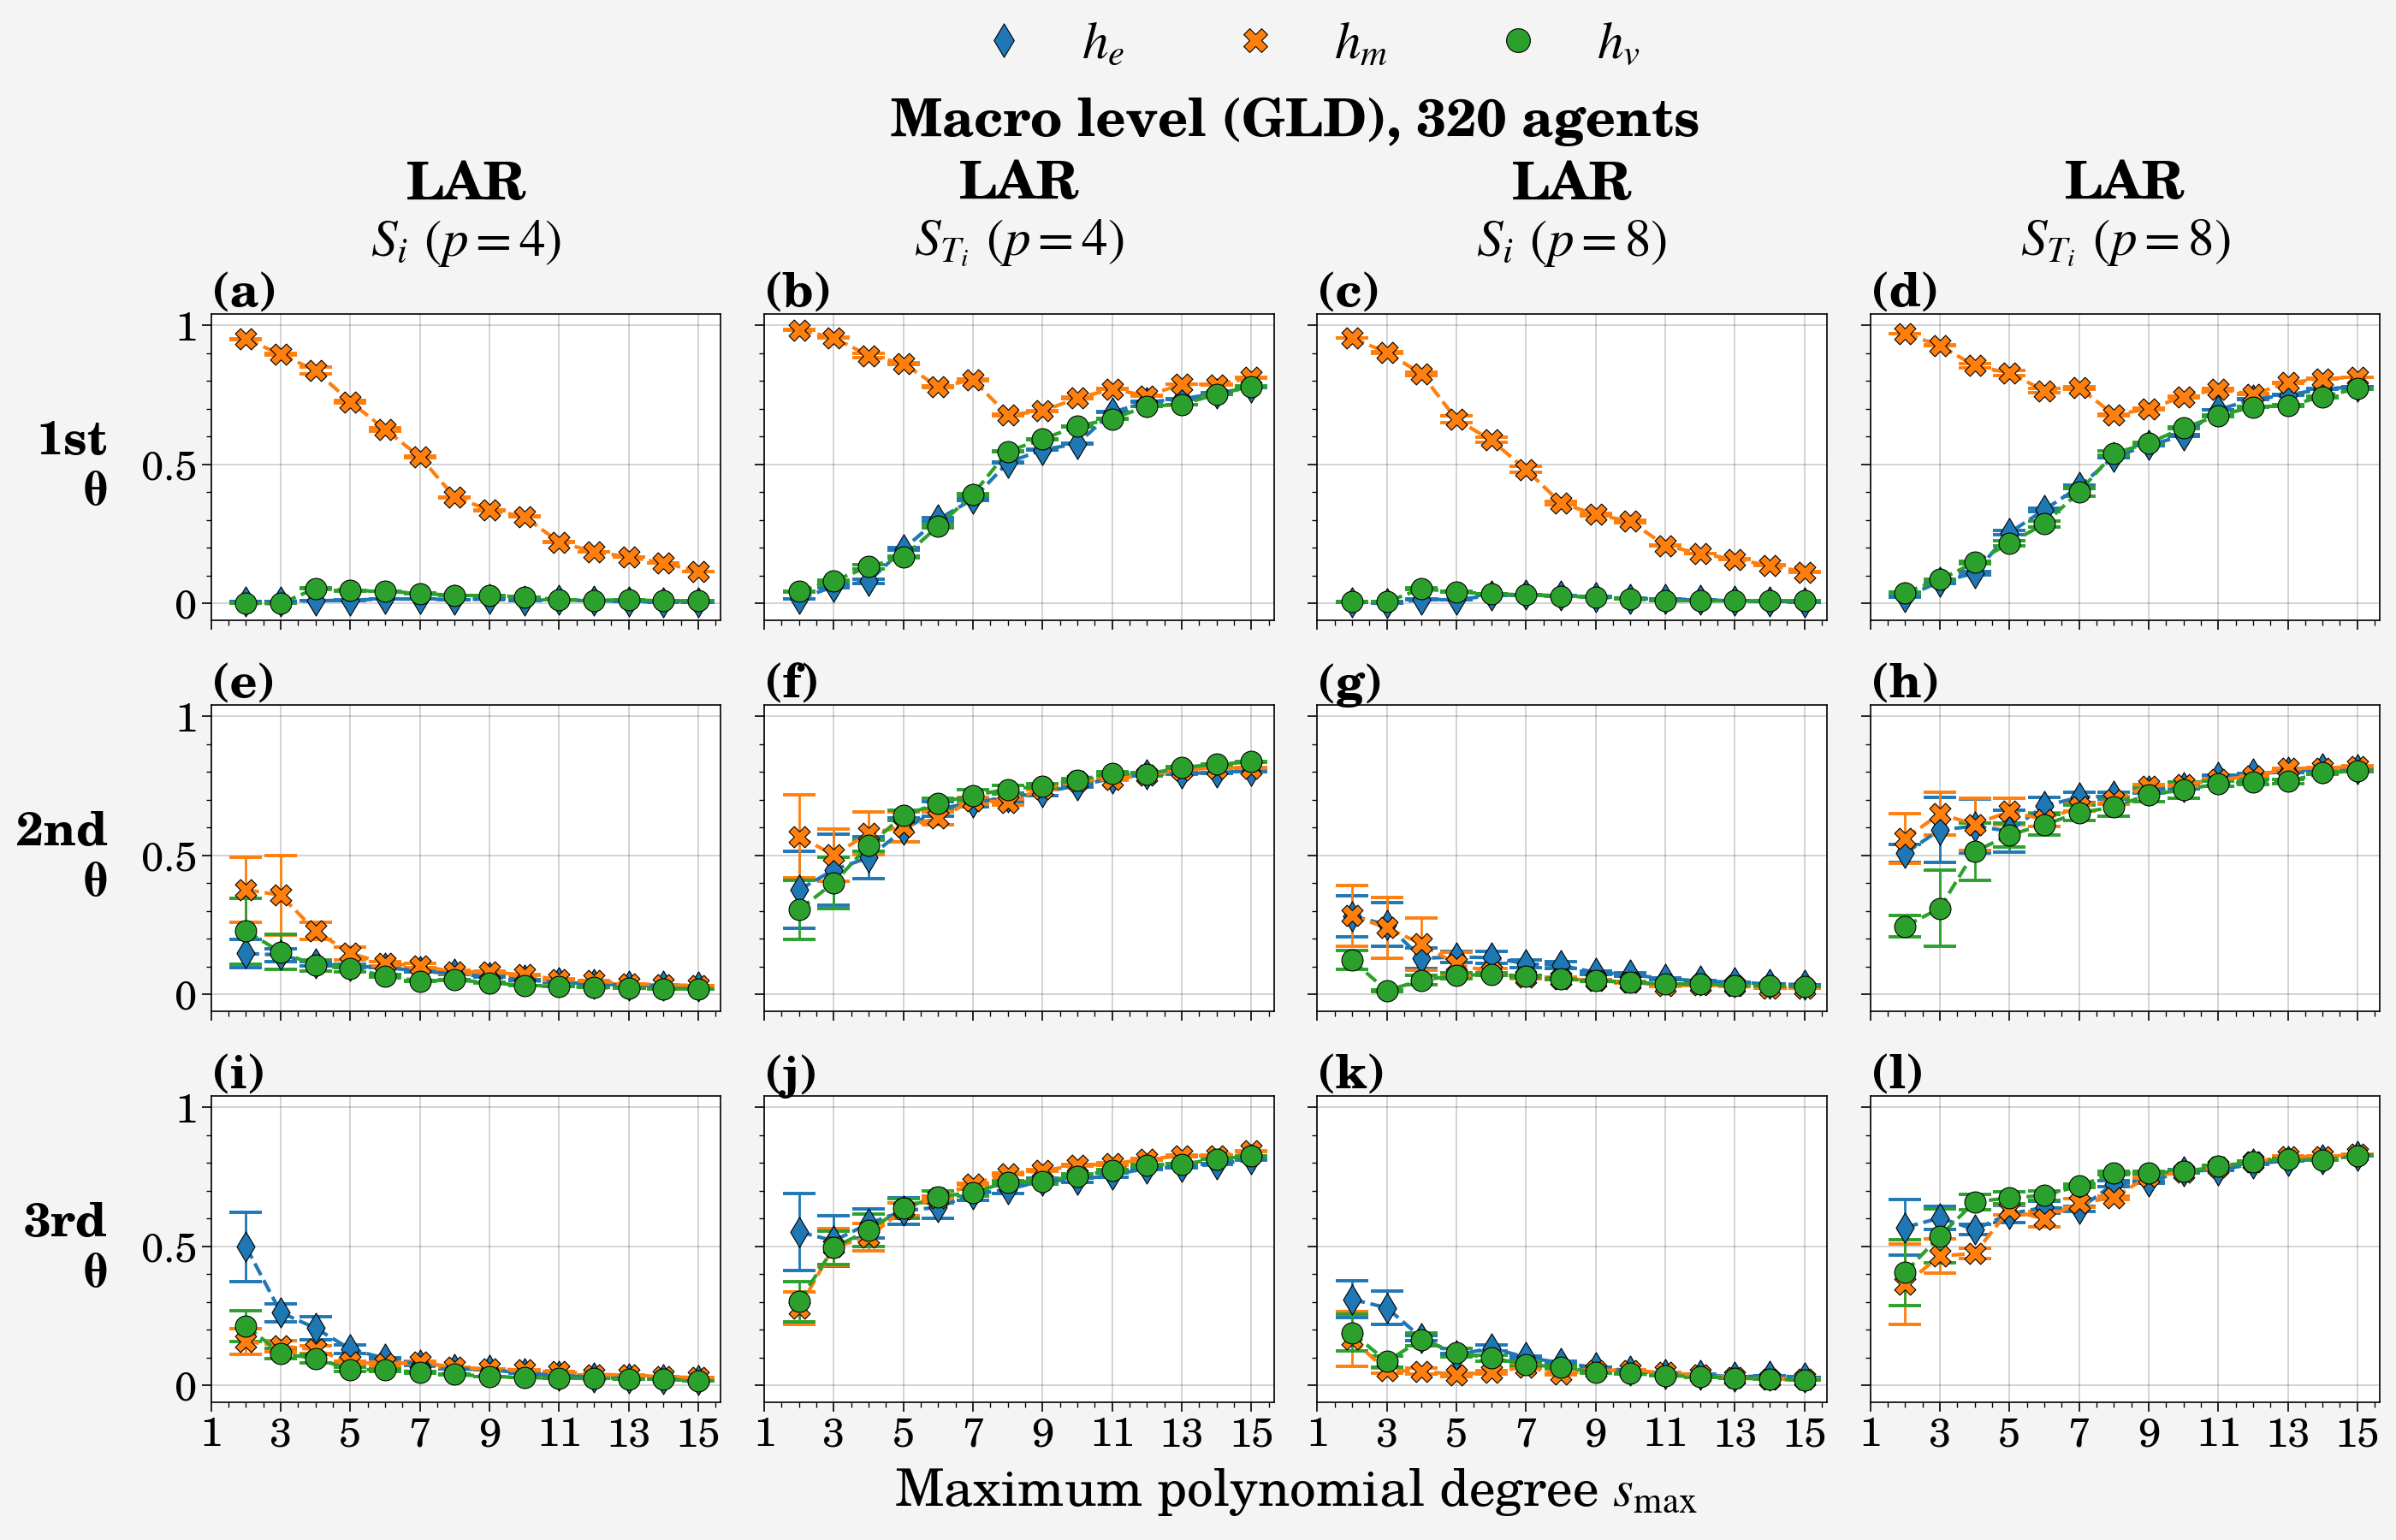

In [12]:
plot_GSA_OLS_LAR(SIs = [LAR_fo_si_GLD_320_p_4, LAR_to_si_GLD_320_p_4, 
                        LAR_fo_si_GLD_320_p_8, LAR_to_si_GLD_320_p_8],
                 figsize = (14, 9),
                 suptitle = "Macro level (GLD), 320 agents", 
                 legend_n_cols  = 3,
                 toplabels = ("LAR\n"+r'$S_{i}$ $({p=4})$', 
                              "LAR\n"+r'$S_{T_i}$ $({p=4})$', 
                              "LAR\n"+r'$S_{i}$ $({p=8})$', 
                              "LAR\n"+r'$S_{T_i}$ $({p=8})$'),
                 title = "SC_GLD_pop320_GSA_LAR.pdf")

## PCE with OLS - appendix

In [13]:
GSA_GLD_100_3 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop100_runs_10_p_3.npz', 
                            allow_pickle=True)

OLS_fo_si_GLD_100_p_3 = GSA_GLD_100_3['x1']
OLS_to_si_GLD_100_p_3 = GSA_GLD_100_3['x2']


GSA_GLD_100_10 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop100_runs_10_p_10.npz', 
                            allow_pickle=True)

OLS_fo_si_GLD_100_p_10 = GSA_GLD_100_10['x1']
OLS_to_si_GLD_100_p_10 = GSA_GLD_100_10['x2']

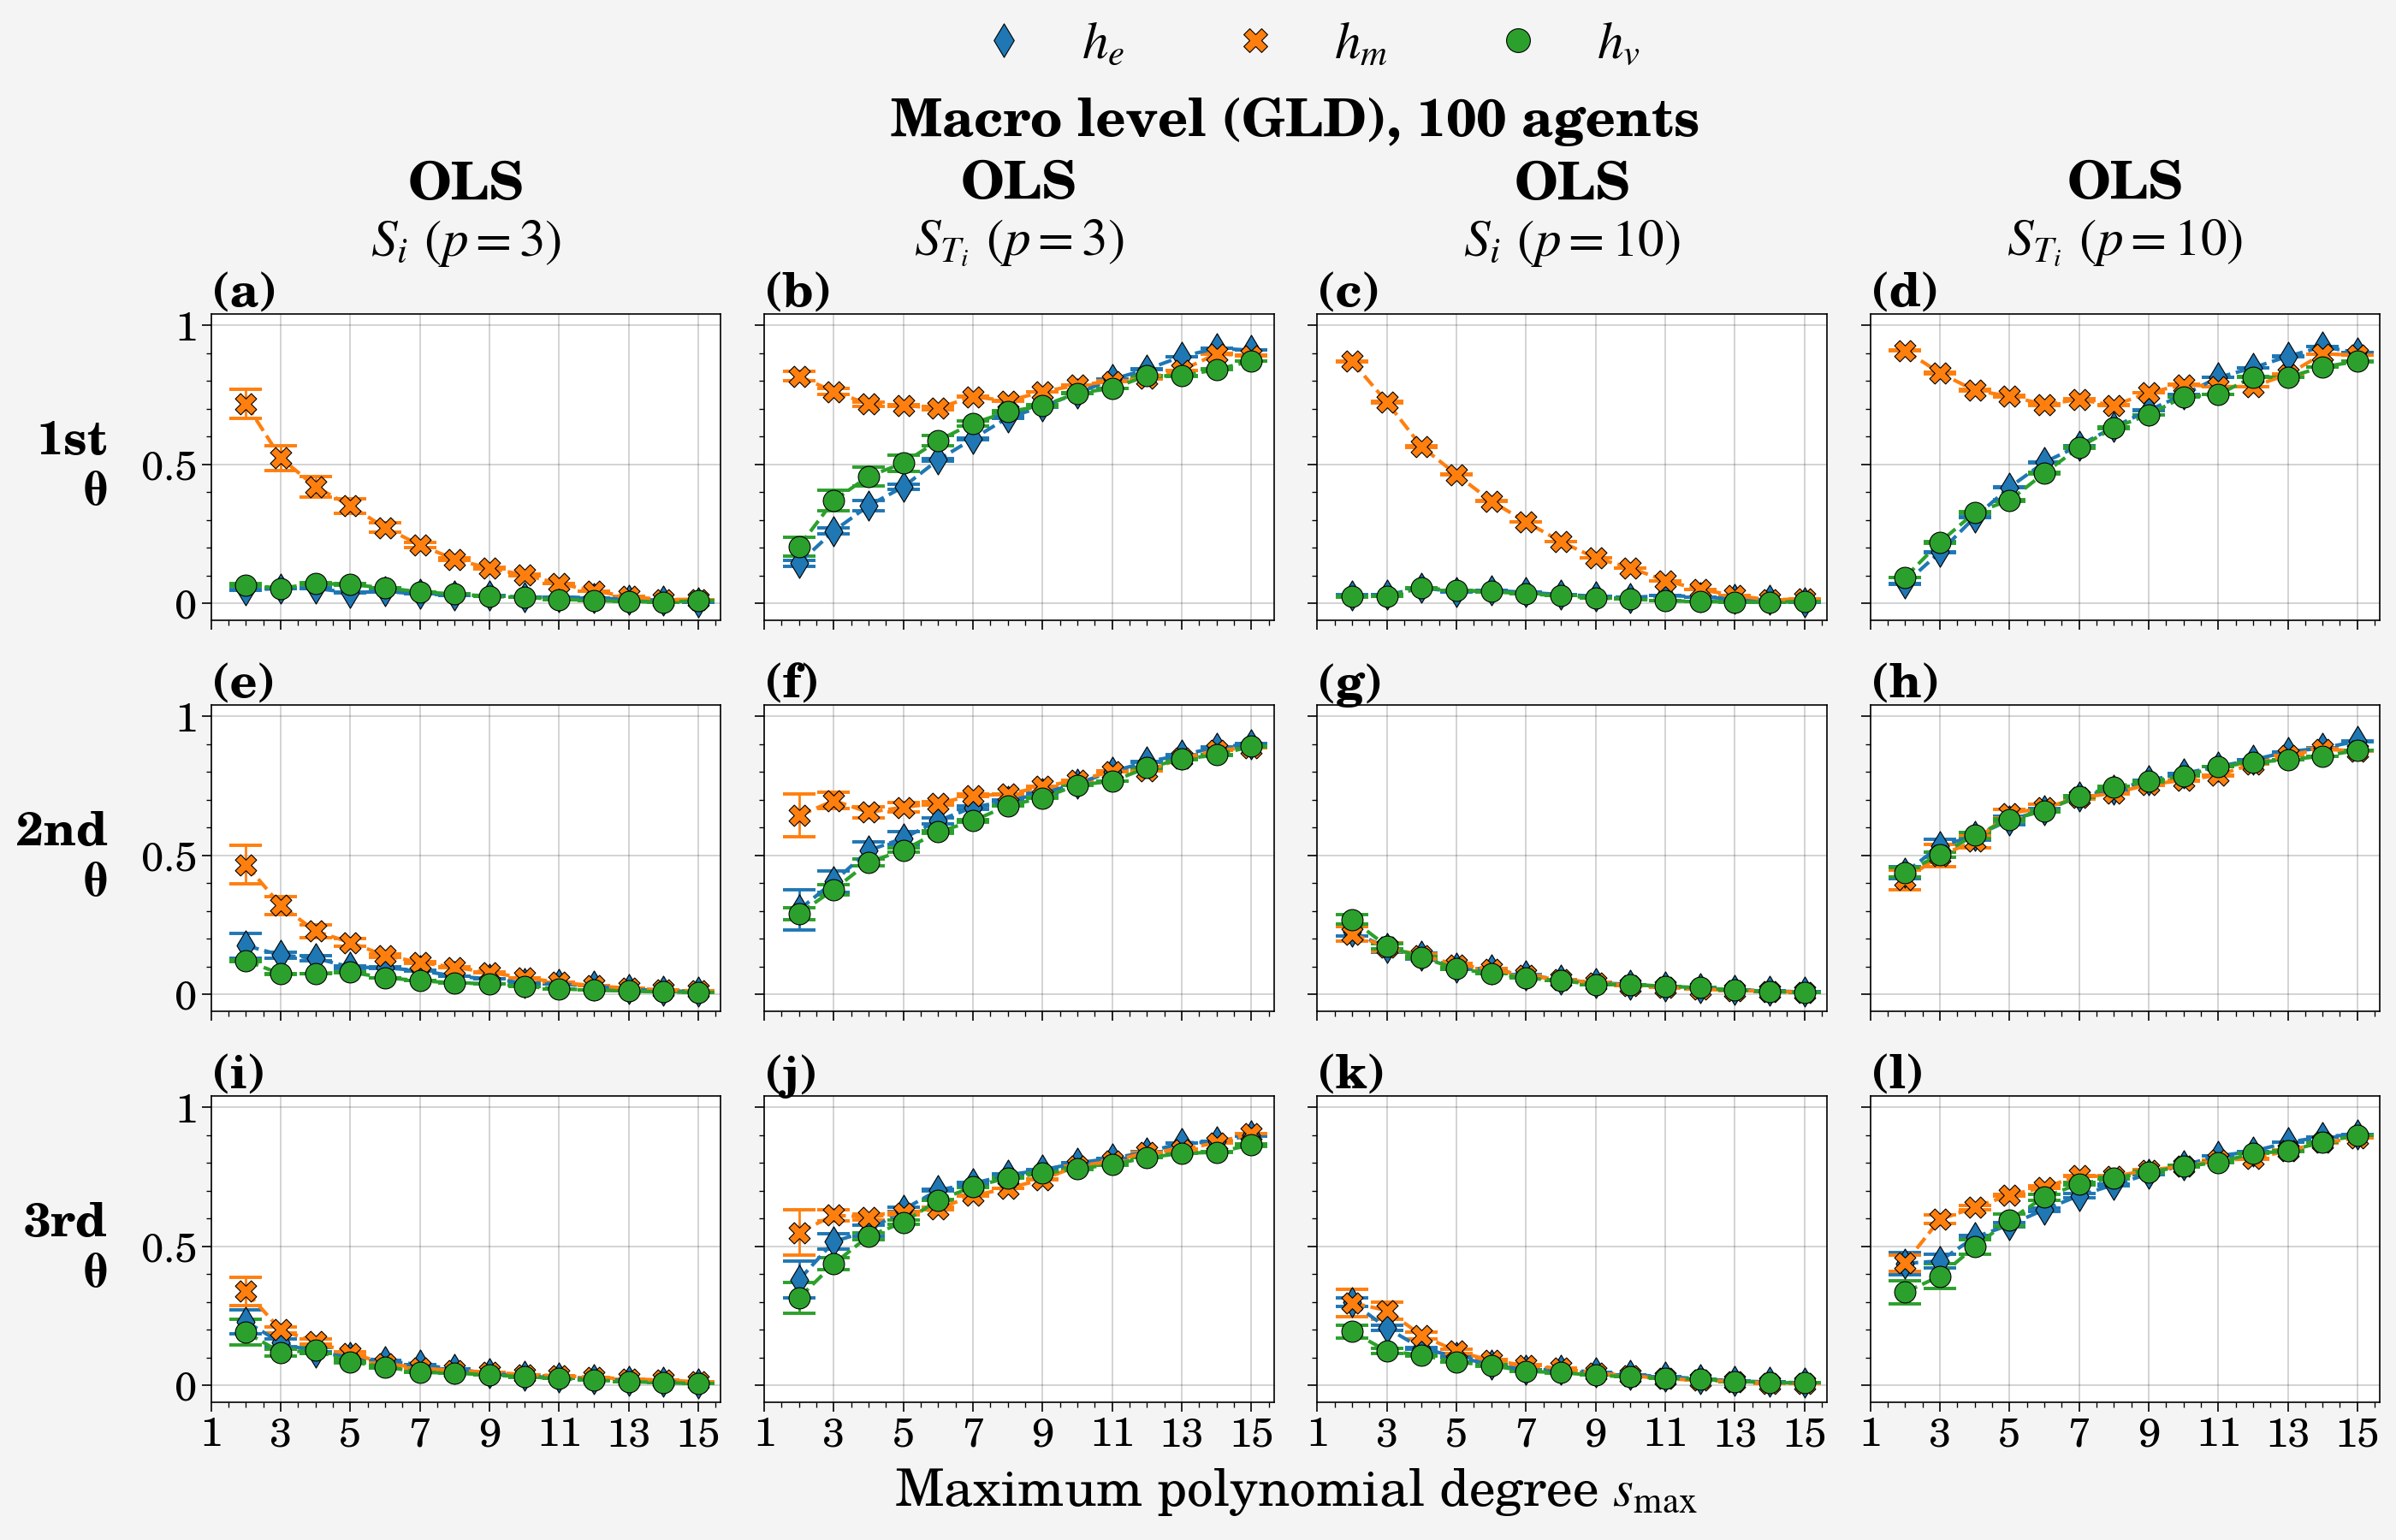

In [15]:
plot_GSA_OLS_LAR(SIs = [OLS_fo_si_GLD_100_p_3, OLS_to_si_GLD_100_p_3, 
                        OLS_fo_si_GLD_100_p_10, OLS_to_si_GLD_100_p_10],
                 figsize = (14, 9),
                 suptitle = "Macro level (GLD), 100 agents", 
                 legend_n_cols  = 3,
                 toplabels = ("OLS\n"+r'$S_{i}$ $({p=3})$', 
                              "OLS\n"+r'$S_{T_i}$ $({p=3})$', 
                              "OLS\n"+r'$S_{i}$ $({p=10})$', 
                              "OLS\n"+r'$S_{T_i}$ $({p=10})$'),
                 title = "SC_GLD_pop100_GSA_OLS.pdf")

In [16]:
GSA_GLD_320_4 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop320_runs_10_p_4.npz', 
                            allow_pickle=True)

OLS_fo_si_GLD_320_p_4 = GSA_GLD_320_4['x1']
OLS_to_si_GLD_320_p_4 = GSA_GLD_320_4['x2']


GSA_GLD_320_8 = np.load(PATH_TO_RESULTS + f'PCE_GSA/GLD_smax_2_15_wMAE_pop320_runs_10_p_8.npz', 
                            allow_pickle=True)

OLS_fo_si_GLD_320_p_8 = GSA_GLD_320_8['x1']
OLS_to_si_GLD_320_p_8 = GSA_GLD_320_8['x2']

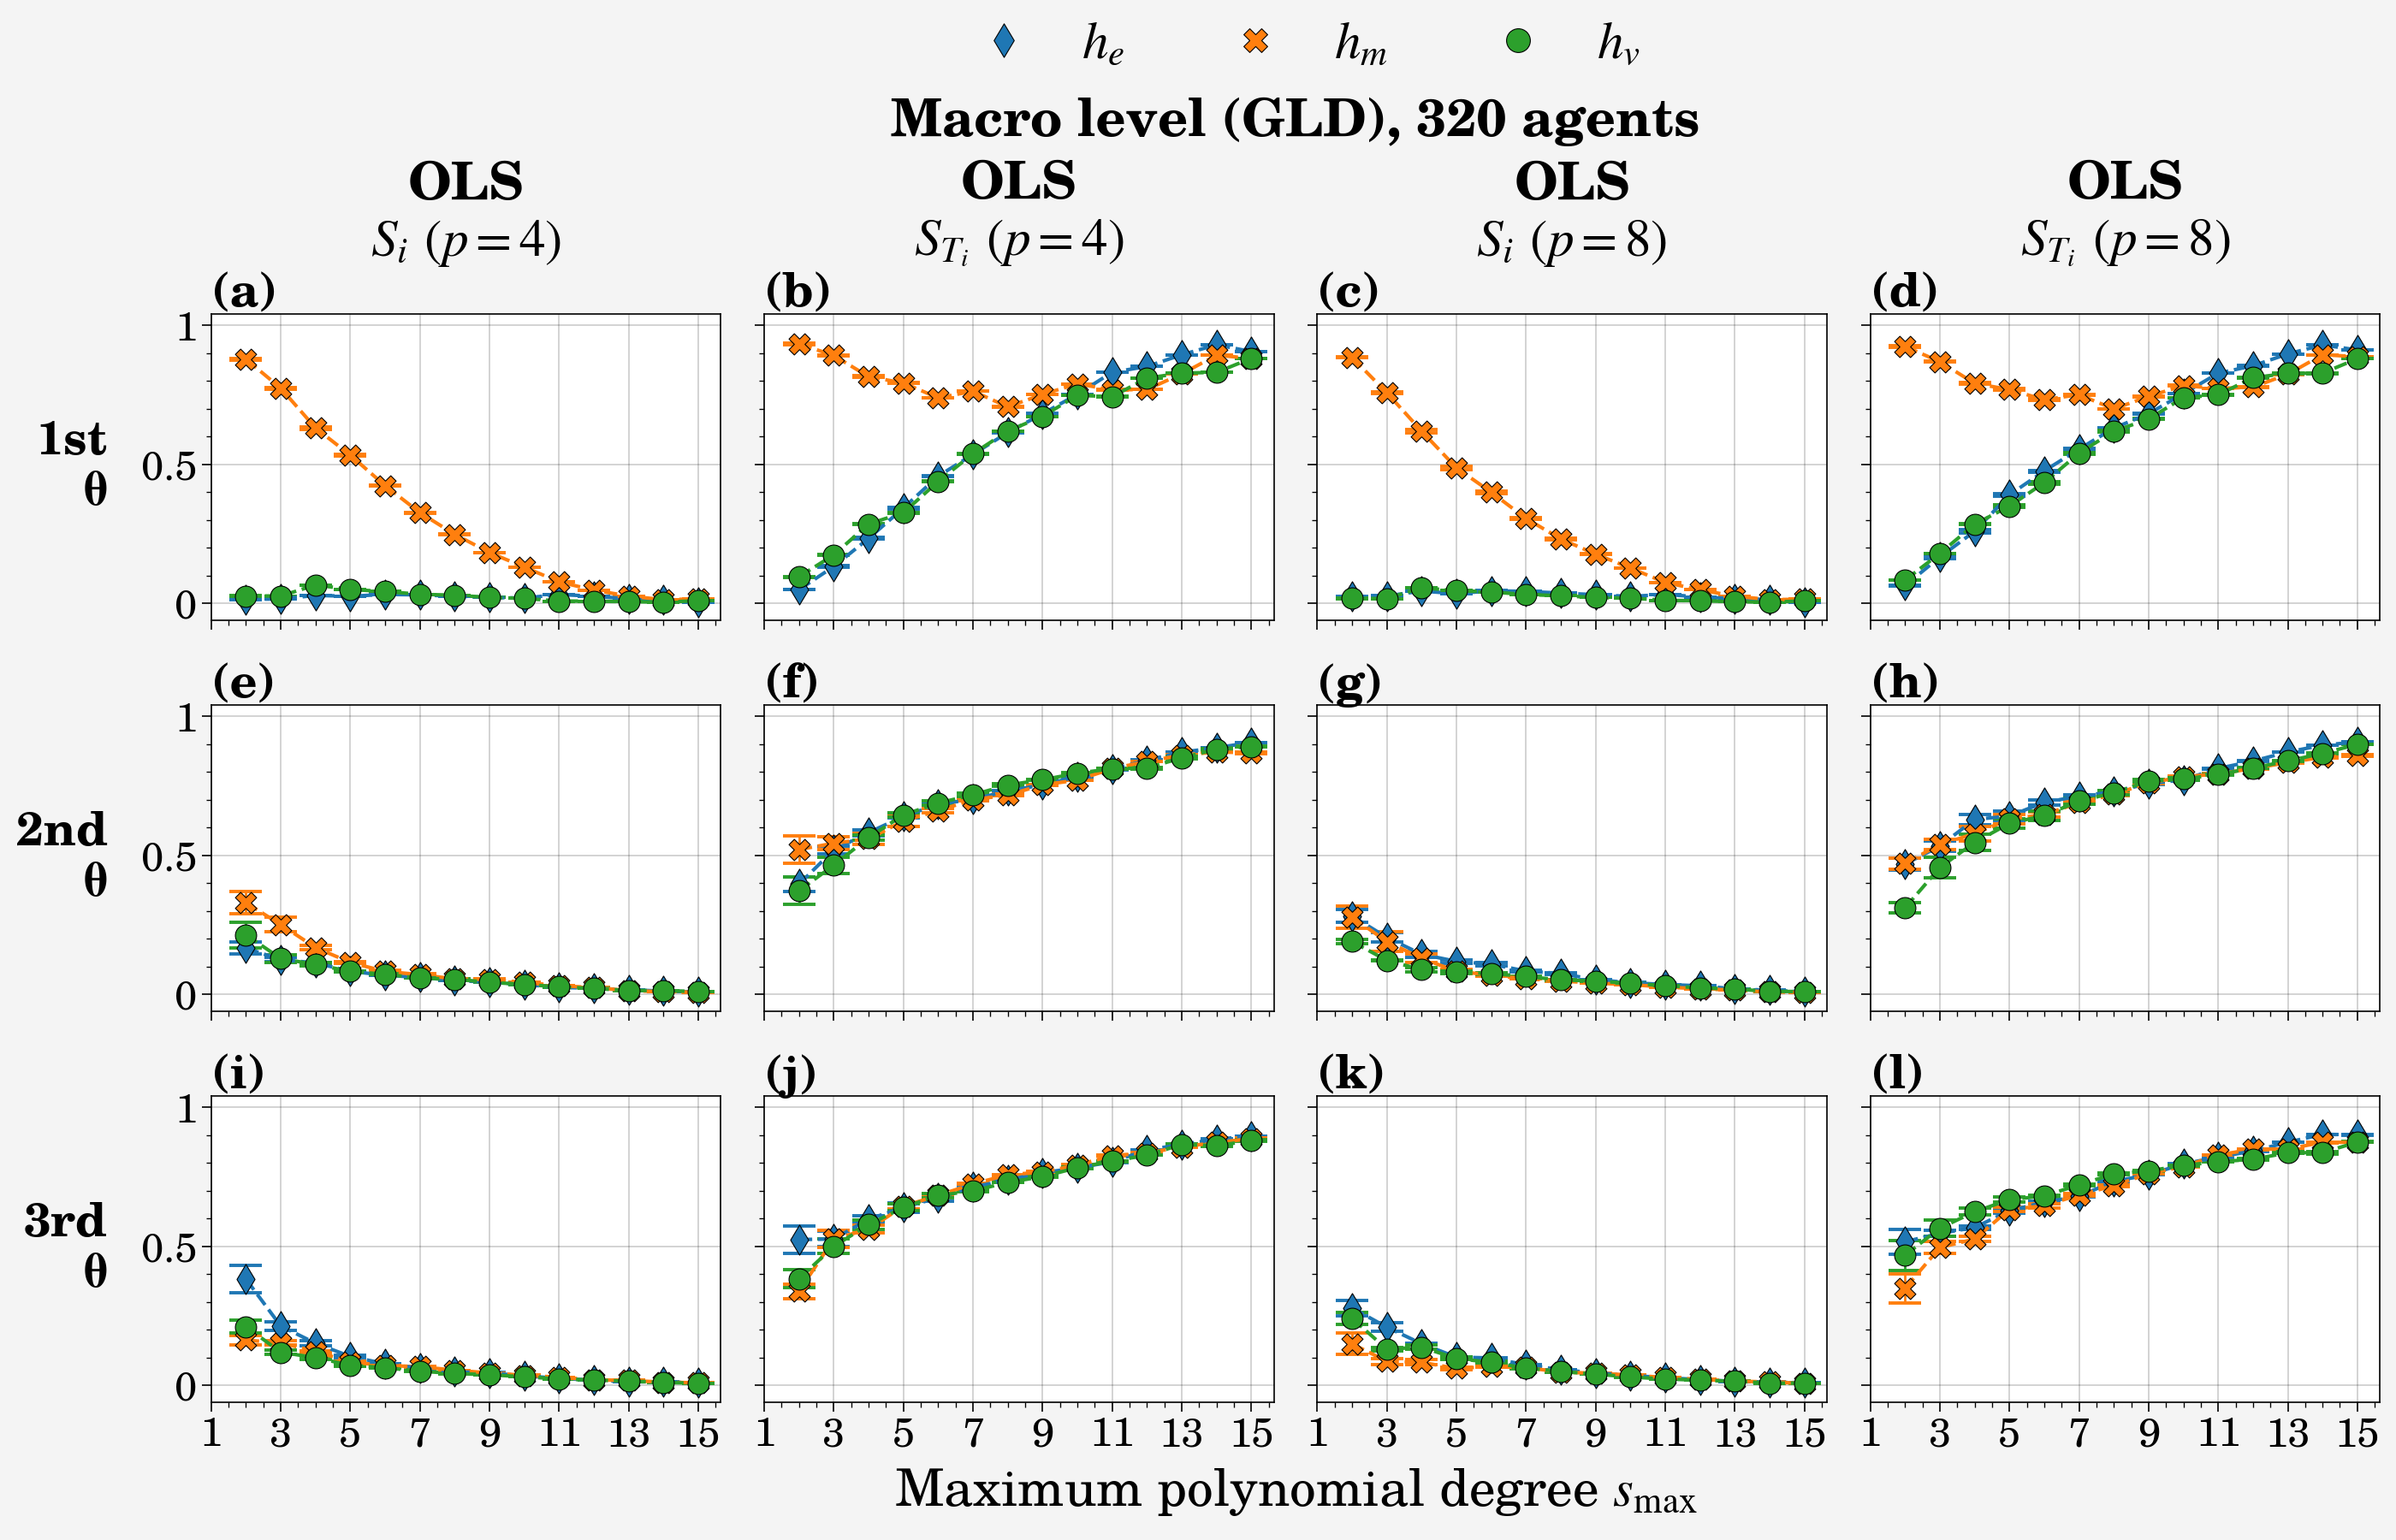

In [17]:
plot_GSA_OLS_LAR(SIs = [OLS_fo_si_GLD_320_p_4, OLS_to_si_GLD_320_p_4, 
                        OLS_fo_si_GLD_320_p_8, OLS_to_si_GLD_320_p_8],
                 figsize = (14, 9),
                 suptitle = "Macro level (GLD), 320 agents", 
                 legend_n_cols  = 3,
                 toplabels = ("OLS\n"+r'$S_{i}$ $({p=4})$', 
                              "OLS\n"+r'$S_{T_i}$ $({p=4})$', 
                              "OLS\n"+r'$S_{i}$ $({p=8})$', 
                              "OLS\n"+r'$S_{T_i}$ $({p=8})$'),
                 title = "SC_GLD_pop320_GSA_OLS.pdf")

## PCE estimation errors

In [18]:
def plot_GSA_errors(errors, n_plot_cols, suptitle, figsize, legend_n_cols, 
                    toplabels, leftlabels, title, top=True):
    
    dcoords = [r"First $\mathbf{\theta}$", r"Second $\mathbf{\theta}$", r"Third $\mathbf{\theta}$"]
    
    s_max = np.linspace(2, 15, 14, dtype='int')

    colors=mcp.gen_color(cmap="Dark2",n=7)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_plot_cols, nrows=4, figsize=figsize, sharex=True, sharey=False)
    
    for j, error in enumerate(errors):
        for i, d in enumerate(dcoords):
            
            axs[j].scatter(s_max, error.mean(axis=0)[:,i], label=dcoords[i],
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=100, linewidth=0.4, zorder=3)
            axs[j].errorbar(s_max, error.mean(axis=0)[:,i],
                              error.var(axis=0, ddof=1)[:,i],
                              markeredgewidth=1.4, color=colors[i],
                              linestyle='--', capsize=7, alpha=1, elinewidth=1) 
   
    axs.format(toplabels=toplabels,
               suptitle=suptitle,
               leftlabels=leftlabels,)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 5.0})
    
    ticks_x = np.linspace(3, 15, 5, dtype='int')
    axs.set_xticks(ticks_x, ['{}'.format(num) for num in ticks_x])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(dcoords, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 4))
        
        for i in range(len(dcoords)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/Sugarscape/' + title, bbox_inches='tight')
    plt.show()

In [19]:
def plot_MAE(errors, n_plot_cols, suptitle, figsize, legend_n_cols, toplabels, title, top=True):
    
    dcoords = [r"First $\mathbf{\theta}$", r"Second $\mathbf{\theta}$", r"Third $\mathbf{\theta}$"]
    
    s_max = np.linspace(2, 15, 14, dtype='int')

    colors=mcp.gen_color(cmap="Dark2",n=7)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_plot_cols, nrows=1, figsize=figsize, sharex=True, sharey=False)
    
    for j, error in enumerate(errors):
        for i, d in enumerate(dcoords):
            
            axs[j].scatter(s_max, error.mean(axis=0)[:,i], label=dcoords[i],
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=100, linewidth=0.4, zorder=3)
            axs[j].errorbar(s_max, error.mean(axis=0)[:,i],
                            error.var(axis=0, ddof=1)[:,i],
                            markeredgewidth=1.4, color=colors[i],
                            linestyle='--', capsize=7, alpha=1, elinewidth=1) 
            axs[j].set_title(r"$\mathrm{MAE}$")
   
    axs.format(toplabels=toplabels,
               suptitle=suptitle)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, -3))
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'title.pad': 20,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.bboxpad': 15.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 10.0})
    
    ticks_x = np.linspace(3, 15, 5, dtype='int')
    axs.set_xticks(ticks_x, ['{}'.format(num) for num in ticks_x])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(dcoords, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 5))
        
        for i in range(len(dcoords)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/Sugarscape/' + title, bbox_inches='tight')
    plt.show()



In [20]:
# GLD_GSA_files = sorted([f for f in os.listdir(PATH_TO_RESULTS + f'PCE_GSA') if 'wMAE' in f])

GLD_GSA_files = ['GLD_smax_2_15_wMAE_pop100_runs_10_p_3.npz',
                 'GLD_smax_2_15_wMAE_pop100_runs_10_p_10.npz',
                 'GLD_smax_2_15_wMAE_pop320_runs_10_p_4.npz',
                 'GLD_smax_2_15_wMAE_pop320_runs_10_p_8.npz']

In [21]:
ols_all_errors = []
LAR_all_errors = []

OLS_LAR_errors_wo_MAE = []
errors_MAE = []

for f in GLD_GSA_files:
    
    GSA_res = np.load(PATH_TO_RESULTS + f'PCE_GSA/' + f, allow_pickle=True)
    
    ols_error = GSA_res['x3']
    ols_LOO   = GSA_res['x4']
    
    LAR_error     = GSA_res['x11']
    LAR_LOO       = GSA_res['x12']  
    LAR_MAE       = GSA_res['x13']
    
    ols_all_errors.append(ols_error)
    ols_all_errors.append(ols_LOO)
    
    LAR_all_errors.append(LAR_error)
    LAR_all_errors.append(LAR_LOO)
    LAR_all_errors.append(LAR_MAE)
    
    OLS_LAR_errors_wo_MAE.append(ols_error)
    OLS_LAR_errors_wo_MAE.append(LAR_error)
    OLS_LAR_errors_wo_MAE.append(ols_LOO)
    OLS_LAR_errors_wo_MAE.append(LAR_LOO)
    errors_MAE.append(LAR_MAE)

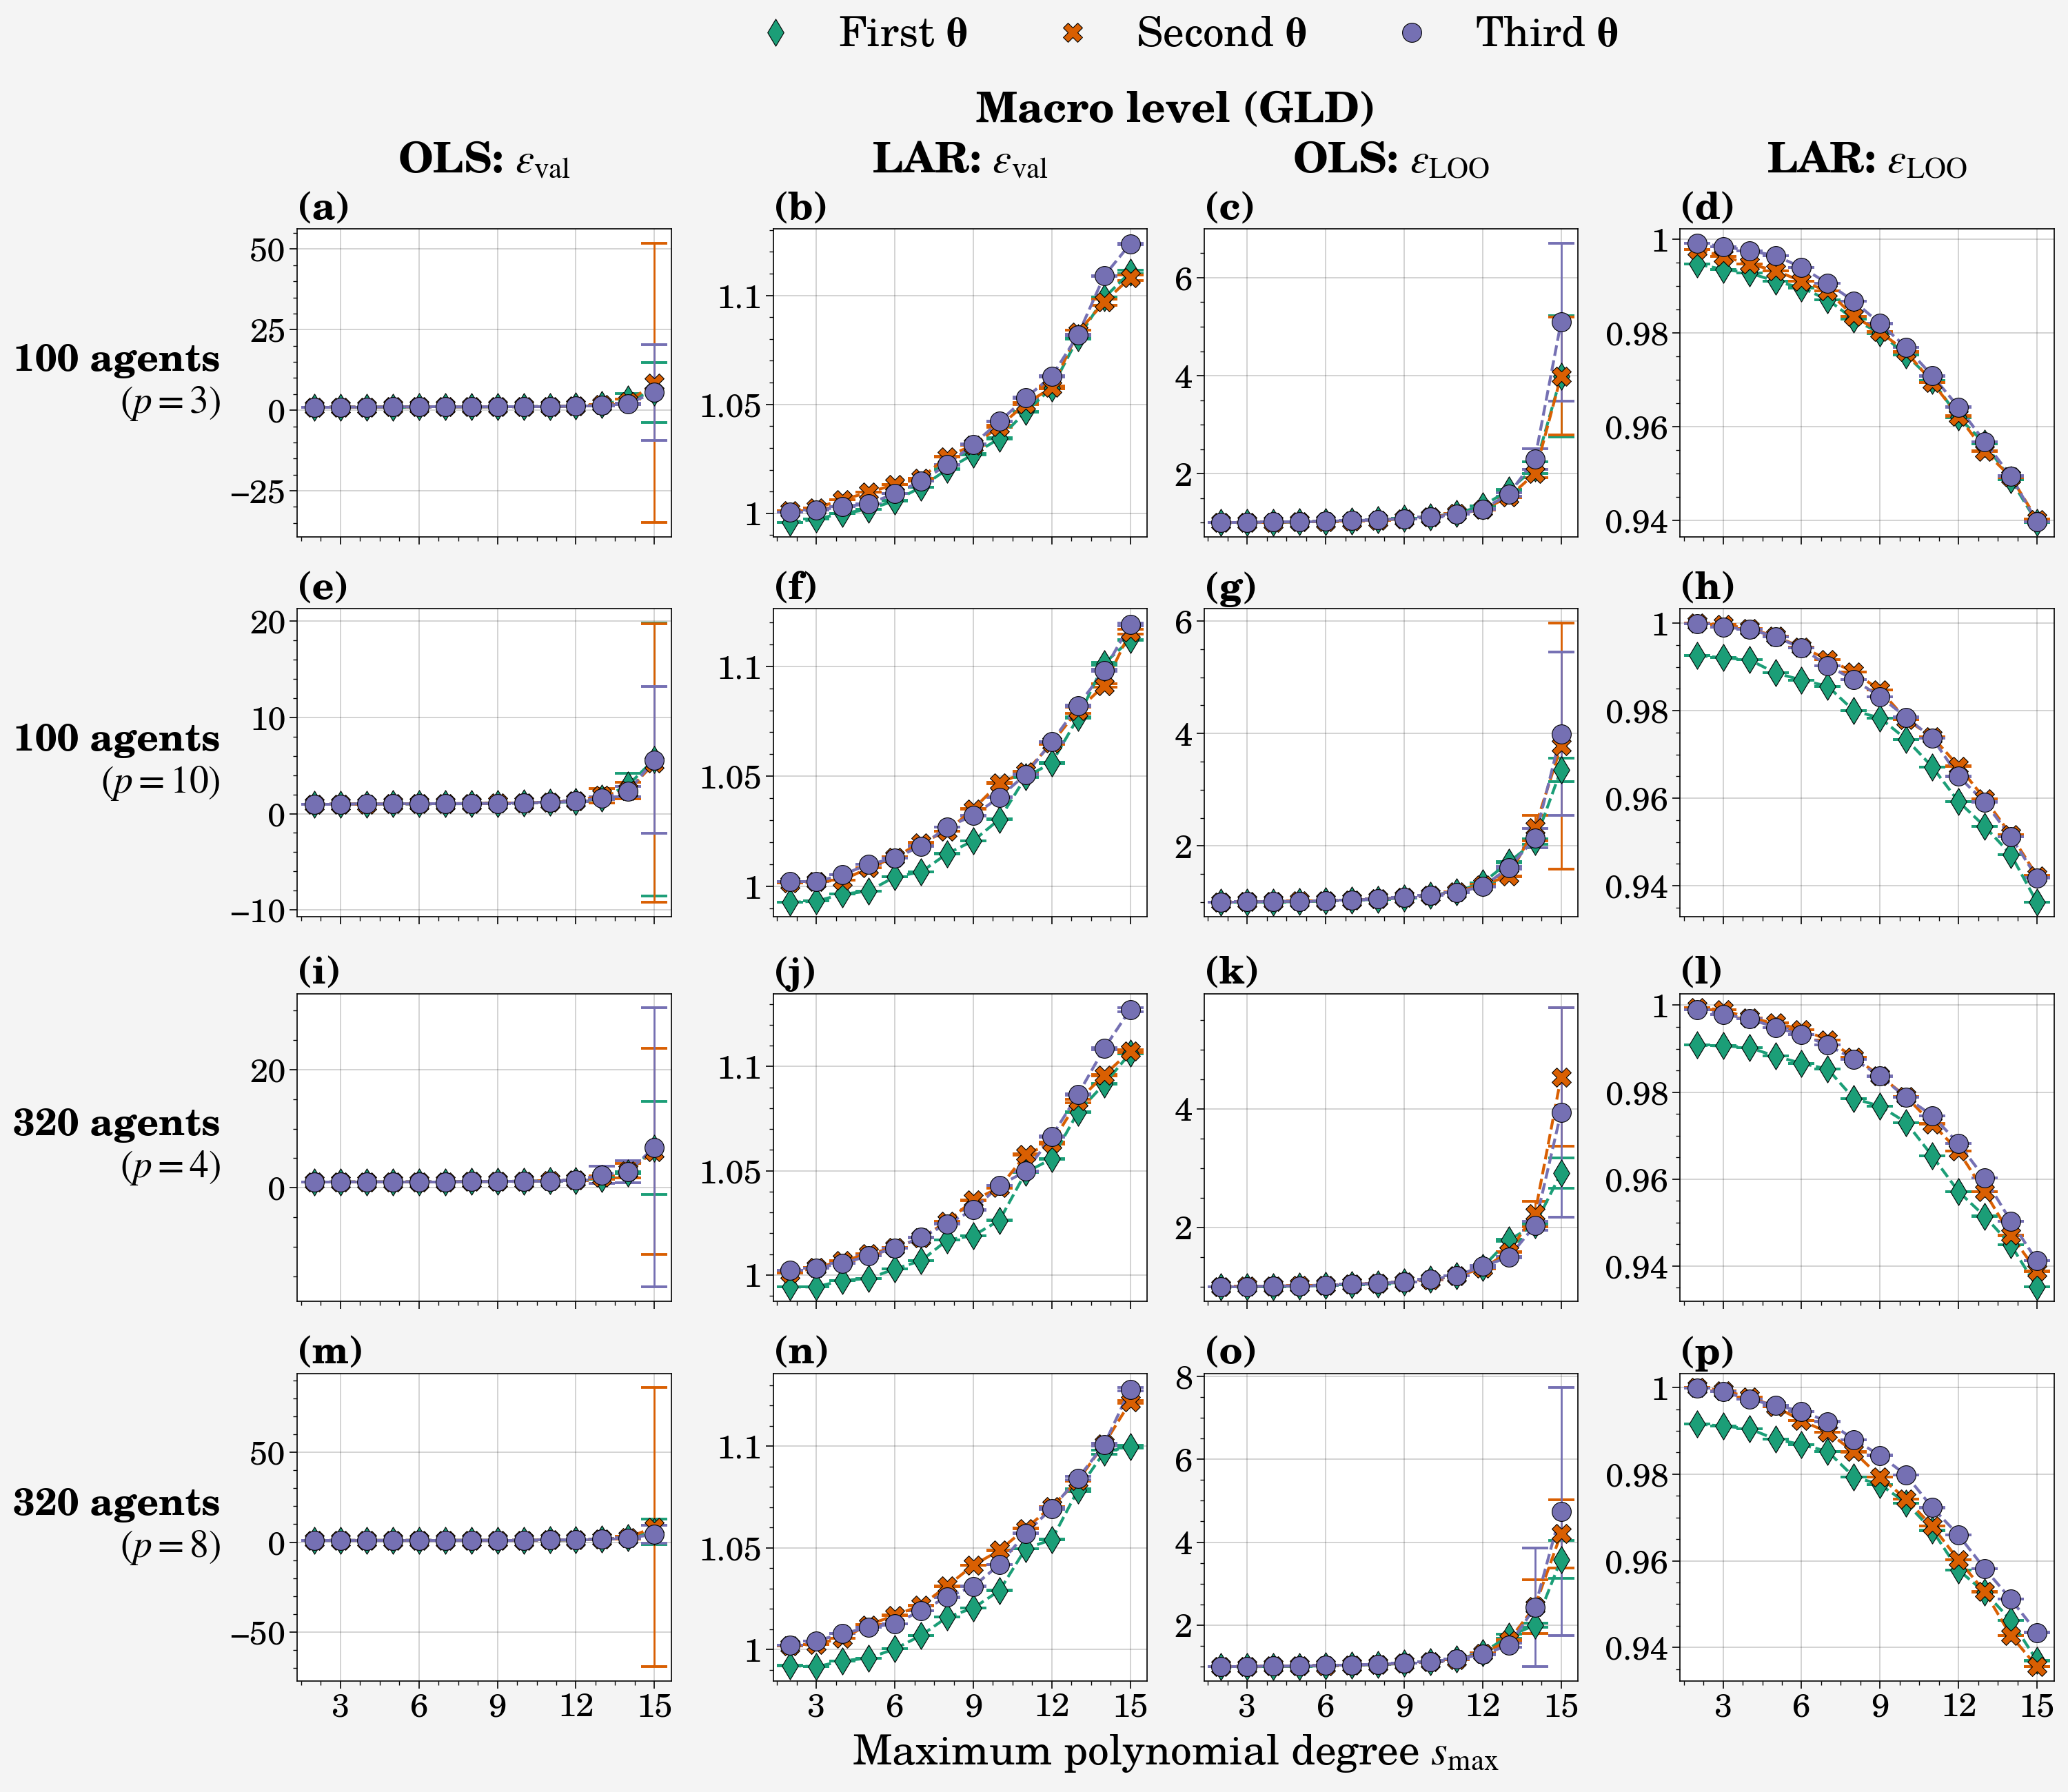

In [22]:
plot_GSA_errors(errors = OLS_LAR_errors_wo_MAE, 
                n_plot_cols = 4,
                suptitle = "Macro level (GLD)", 
                figsize = (15, 13),
                legend_n_cols = 3, 
                toplabels = (r"OLS: $\epsilon_{\mathrm{val}}$", 
                             r"LAR: $\epsilon_{\mathrm{val}}$",
                             r"OLS: $\epsilon_{\mathrm{LOO}}$",
                             r"LAR: $\epsilon_{\mathrm{LOO}}$",), 
                leftlabels=["100 agents\n"+r"$(p=3)$", 
                            "100 agents\n"+r"$(p=10)$",
                            "320 agents\n"+r"$(p=4)$",
                            "320 agents\n"+r"$(p=8)$"], 
                title = "SC_GLD_OLS_LAR_errors_wo_MAE.pdf", 
                top=True)


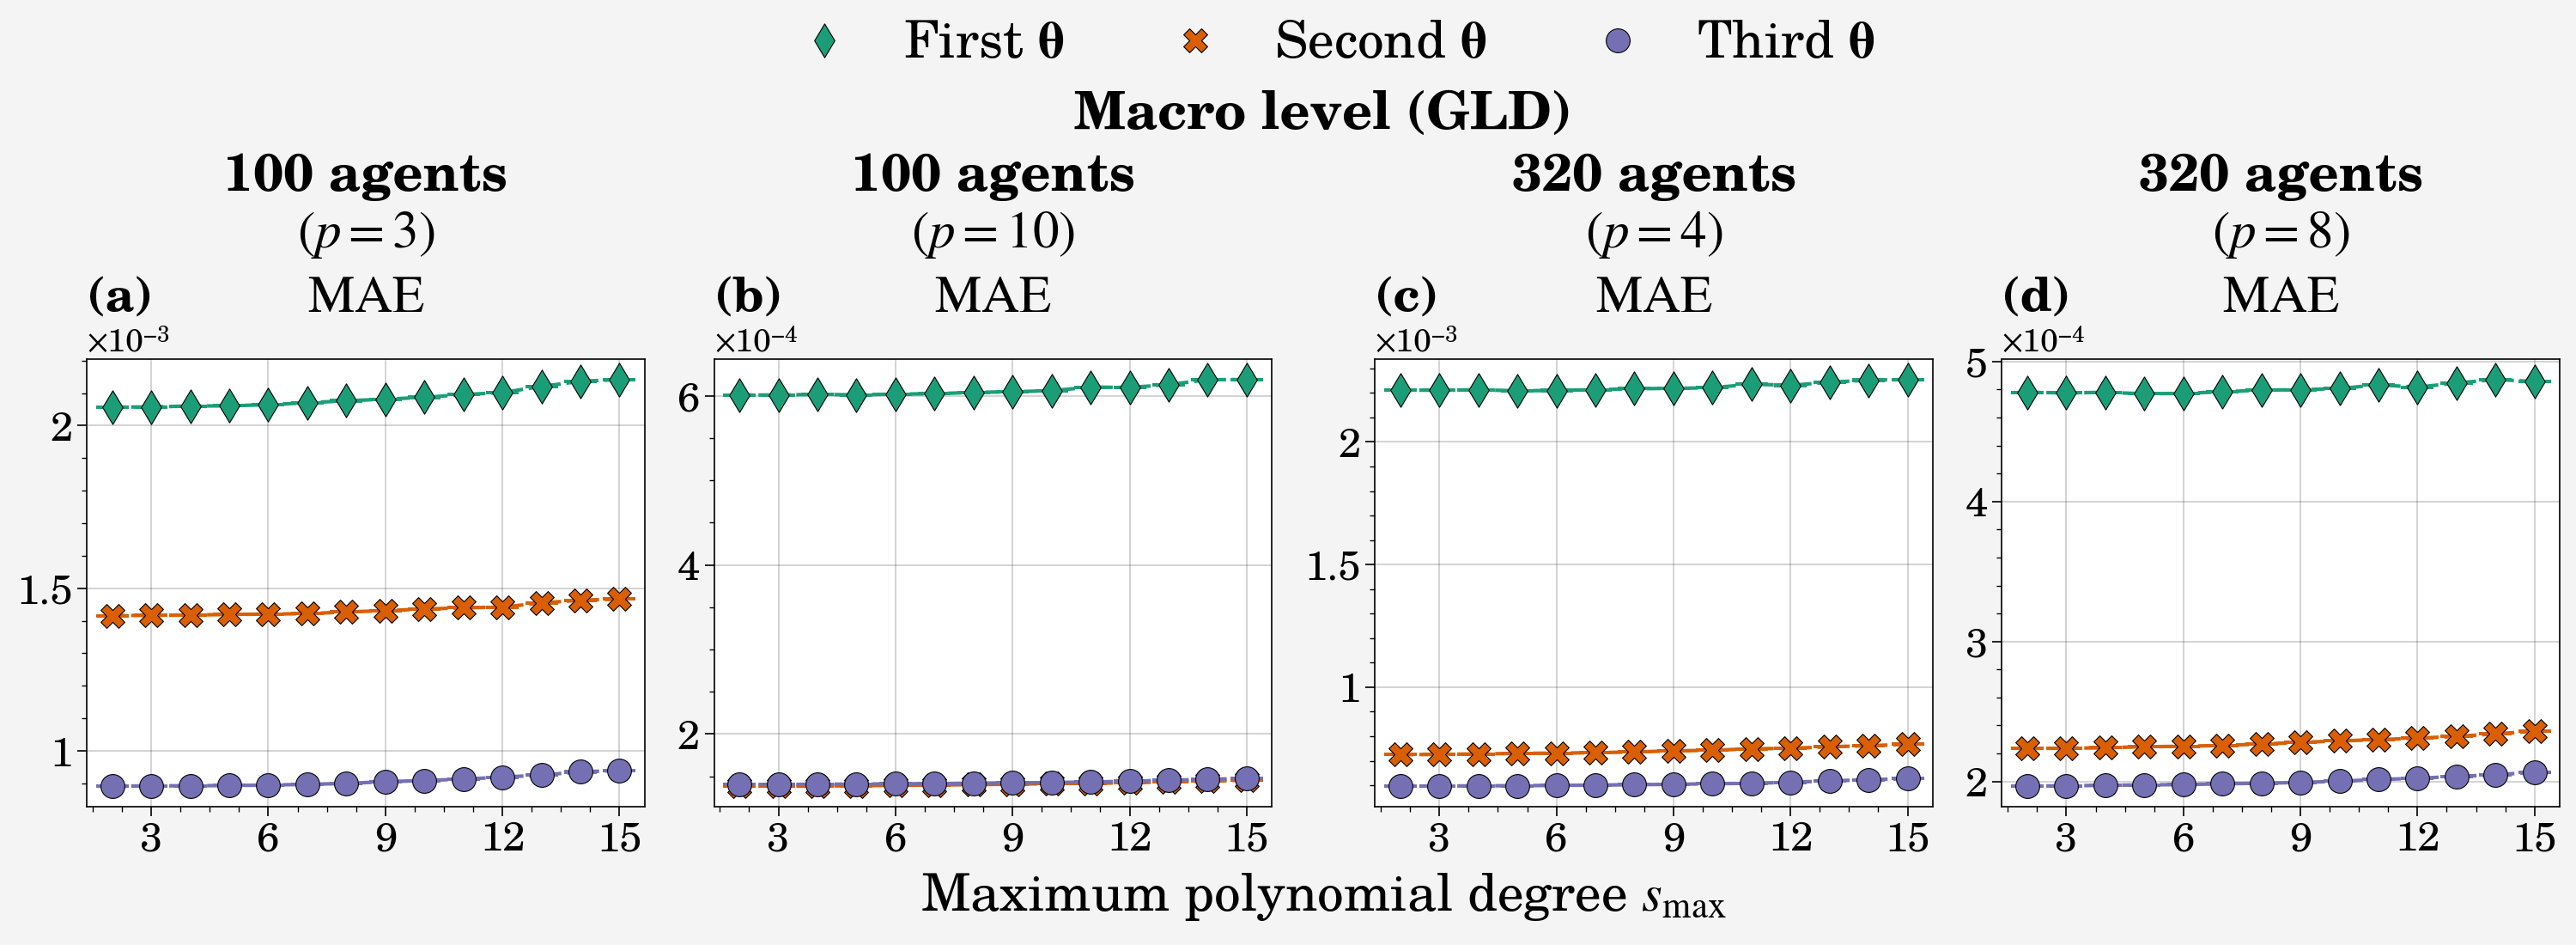

In [23]:
plot_MAE(errors = errors_MAE, 
        n_plot_cols = 4,
        suptitle = "Macro level (GLD)", 
        figsize = (15, 5.5),
        legend_n_cols = 3, 
        toplabels = ("100 agents\n"+r"$(p=3)$", 
                     "100 agents\n"+r"$(p=10)$",
                     "320 agents\n"+r"$(p=4)$",
                     "320 agents\n"+r"$(p=8)$"),
        title = "SC_GLD_LAR_MAE.pdf", 
        top=True)